In [41]:
import pandas as pd 
import numpy as np
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt 
from sklearn import tree,preprocessing
from sklearn.model_selection import train_test_split,cross_validate,KFold,StratifiedKFold,GridSearchCV,learning_curve,PredefinedSplit
from sklearn.metrics import precision_score,recall_score,confusion_matrix,accuracy_score,make_scorer,f1_score,SCORERS
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from copy import deepcopy
import time
import seaborn as sns
from random import shuffle,sample
from xgboost import XGBClassifier as xgbc

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale
from sklearn.impute import SimpleImputer
from sklearn.utils import shuffle as sh

def c_learning_curve(estimator,X,y,scoring,v):
    if v=='k':
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    else:
        fold=[-1]*(len(X)-500)+[0]*100+[1]*100+[2]*100+[3]*100+[4]*100
        shuffle(fold)
        cv=PredefinedSplit(test_fold=fold)
        
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator,X,y, cv= cv, n_jobs=-1,
                           train_sizes=[0.1,0.25,0.5,0.75,0.9,1],return_times=True,scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    return(train_sizes,train_scores_mean,test_scores_mean,fit_times_mean)

def plot_learning_curve(model_results,subplot,model_name):
    model_results=model_results.drop(['Unnamed: 0'],axis=1)
    model_results_trans=pd.DataFrame(data={'Training Size':model_results.iloc[0],'Training Value':model_results.iloc[1],'CV Value':model_results.iloc[2],'Fit Time':model_results.iloc[3]})
    model_results_transmlt=model_results_trans.melt(id_vars=['Training Size'],value_vars=['Training Value','CV Value'])
    sns.lineplot(ax=axs[subplot,0],data=model_results_transmlt,x='Training Size',y='value',hue='variable')
    axs[subplot,0].set_title('Learning Curve for '+model_name)
    if subplot>0:
        axs[subplot,0].get_legend().remove()
    
    sns.lineplot(ax=axs[subplot,1],data=model_results_trans,x='Training Size',y='Fit Time')
    axs[subplot,1].set_title('Fit Time for '+model_name)


# Load Dataset 1

In [42]:
# Load the data
dataset = pd.read_csv('creditcard.csv')
dataset['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [43]:
# Split into training test, x and Y

df_train, df_test = train_test_split(dataset, test_size=0.2, random_state=40)

df_train_x=df_train.loc[:, df_train.columns != 'Class']
df_train_y=df_train.loc[:, df_train.columns == 'Class']

df_test_x=df_test.loc[:, df_train.columns != 'Class']
df_test_y=df_test.loc[:, df_train.columns == 'Class']

# Feature Importance

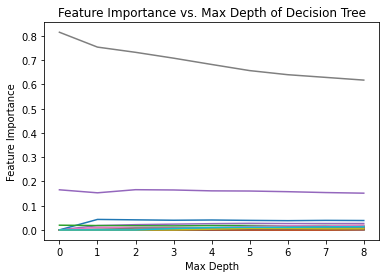

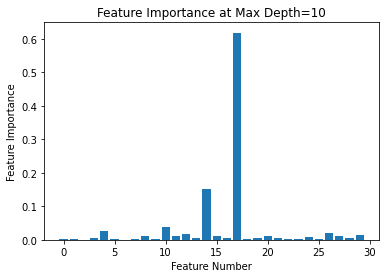

In [44]:
base_tree = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = 10,  min_samples_split = 5,
                              min_samples_leaf = 2)

# Check feature importance to potentially remove unimportant features
trees =[tree.DecisionTreeClassifier(criterion = "entropy", max_depth = i,  min_samples_split = 5,
                              min_samples_leaf = 2)for i in range(2,11)]

trees_fit=[a_tree.fit(df_train_x,df_train_y) for a_tree in trees]
importances=[a_tree.feature_importances_ for a_tree in trees_fit]

importances_df=pd.DataFrame(list(map(np.ravel, importances)))

plt.plot(importances_df)
plt.xlabel("Max Depth")
plt.ylabel("Feature Importance")
plt.title("Feature Importance vs. Max Depth of Decision Tree")
plt.show()

plt.bar(x=range(0,30),height=importances[8])
plt.xlabel("Feature Number")
plt.ylabel("Feature Importance")
plt.title("Feature Importance at Max Depth=10")
plt.show()

importances10=pd.DataFrame({'featureNum':range(0,30),'importance':importances[8]})
importances10['rank']=importances10["importance"].rank(ascending=False)

In [45]:
# Keep most important variables 

df_train15=df_train.iloc[:,importances10[importances10['rank']<=15]['featureNum']]
df_train15['Class']=df_train.loc[:, df_train.columns == 'Class'].values

df_test15=df_test.iloc[:,importances10[importances10['rank']<=15]['featureNum']]
df_test15['Class']=df_test.loc[:, df_test.columns == 'Class'].values

df_test15_x=df_test15.loc[:, df_test15.columns != 'Class']
df_test15_y=df_test15.loc[:, df_test15.columns == 'Class']

# split training into training and validation for hyperparam tuning

df_train15_train,df_train15_validation=train_test_split(df_train15, test_size=0.2, random_state=40)

df_train15_trainx=df_train15_train.loc[:, df_train15_train.columns != 'Class']
df_train15_trainy=df_train15_train.loc[:, df_train15_train.columns == 'Class']

df_train15_validationx=df_train15_train.loc[:, df_train15_validation.columns != 'Class']
df_train15_validationy=df_train15_train.loc[:, df_train15_validation.columns == 'Class']


# noticed that the above validation set is actually pulling from the training set. 
# keeping for testing purposes but will be replacing with below
df_train15_validationx_fixed=df_train15_validation.loc[:, df_train15_validation.columns != 'Class']
df_train15_validationy_fixed=df_train15_validation.loc[:, df_train15_validation.columns == 'Class']


<ipython-input-45-2e0590d528cc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train15['Class']=df_train.loc[:, df_train.columns == 'Class'].values
<ipython-input-45-2e0590d528cc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test15['Class']=df_test.loc[:, df_test.columns == 'Class'].values


# Dataset 1: Decision Trees

In [46]:
# Hyperparameter search for oversampling and class weights

sample_strategies=[0.005,0.01,0.05,0.1,0.2,0.5]
weights = np.linspace(0.0,0.99,10)


#Creating a dictionary grid for grid search
param_grid = [{0:x, 1:1.0-x} for x in weights]
param_grid.append('balanced')

def oversamples(strategy):
    oversample=RandomOverSampler(sampling_strategy=strategy)
    x_over,y_over=oversample.fit_resample(df_train15_trainx,df_train15_trainy)
    return (x_over,y_over)

samples=[oversamples(strategy) for strategy in sample_strategies]

trees_fit=[]
param_list=[]
i=0
for sample in samples:
    for params in param_grid:
        base_tree = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = 10,  min_samples_split = 5,
                              min_samples_leaf = 2,class_weight=params)
        base_tree.fit(sample[0],sample[1])
        model_copy=deepcopy(base_tree)
        trees_fit.append(model_copy)
        param_list.append((sample_strategies[i],params if type(params)is not dict else round(params[1],2)))
    i+=1

trees_validate=[tree.predict(df_train15_validationx) for tree in trees_fit]
trees_precision=[precision_score(prediction,df_train15_validationy) for prediction in trees_validate]
trees_recall=[recall_score(prediction,df_train15_validationy) for prediction in trees_validate]
trees_f1=[f1_score(prediction,df_train15_validationy) for prediction in trees_validate]

trees_testing=[tree.predict(df_test15_x) for tree in trees_fit]
trees_f1_testing=[f1_score(prediction,df_test15_y) for prediction in trees_testing]
trees_valid_test_diff=[abs(trees_f1_testing[i]-trees_f1[i]) for i in range(len(trees_f1_testing))]

param_list=pd.DataFrame(param_list)
param_list['precision']=trees_precision
param_list['recall']=trees_recall
param_list['f1']=trees_f1
param_list['validation_testing_diff']=trees_valid_test_diff

param_list.rename(columns={0:"oversample_rate",1:"class1_weight"},inplace=True)

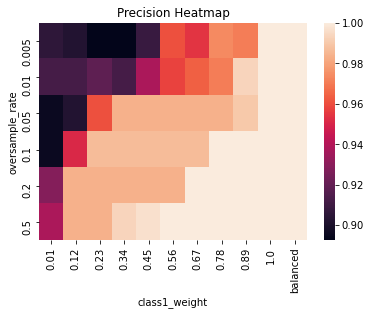

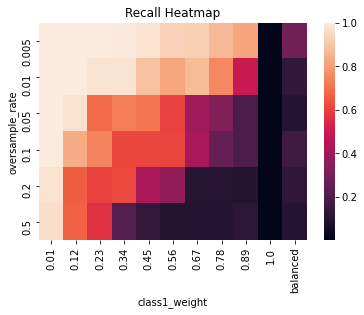

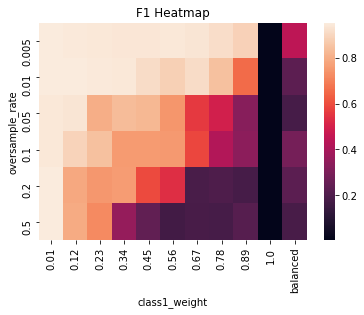

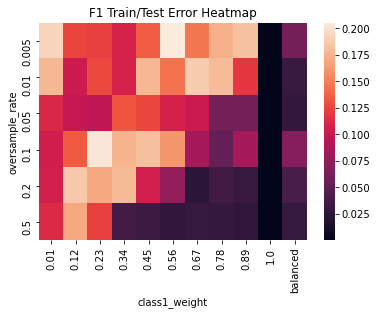

In [47]:
# Visualize output of param search
sns.heatmap(param_list.pivot(index='oversample_rate', columns='class1_weight', values='precision'))
plt.title('Precision Heatmap')
plt.show()

sns.heatmap(param_list.pivot(index='oversample_rate', columns='class1_weight', values='recall'))
plt.title('Recall Heatmap')
plt.show()

sns.heatmap(param_list.pivot(index='oversample_rate', columns='class1_weight', values='f1'))
plt.title('F1 Heatmap')
plt.show()

sns.heatmap(param_list.pivot(index='oversample_rate', columns='class1_weight', values='validation_testing_diff'))
plt.title('F1 Train/Test Error Heatmap')
plt.show()

In [48]:
# Select hyperparameters 
param_list.loc[(np.where((param_list['recall']>0.95) & (param_list['precision']>0.90)))]
final_oversample=0.1
final_weights={0:0.99,1:0.01}

df_train15_x=df_train15_trainx.append(df_train15_validationx)
df_train15_y=df_train15_trainy.append(df_train15_validationy)

base_tree = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = 4,  min_samples_split = 5,
                              min_samples_leaf = 2,class_weight=final_weights)

oversample=RandomOverSampler(sampling_strategy=final_oversample)
x_over,y_over=oversample.fit_resample(df_train15_x,df_train15_y)

base_tree.fit(x_over,y_over)
pred_test=base_tree.predict(df_test15_x)

In [49]:
# Max Depth with cross validation
max_depth = range(1, 17, 2)
param_grid = dict(max_depth=max_depth)
#scoring = {'f1': 'f1', 'precision': 'precision','recall':'recall'}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

base_tree = tree.DecisionTreeClassifier(criterion = "entropy", min_samples_split = 5,
                              min_samples_leaf = 2,class_weight=final_weights)

grid_search = GridSearchCV(base_tree, param_grid, scoring='f1', n_jobs=-1, cv=kfold, verbose=1,refit=False)
grid_result = grid_search.fit(x_over, y_over)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot
plt.errorbar(max_depth, means, yerr=stds)
plt.title("Max Depth vs. F1 Score")

grid_search = GridSearchCV(base_tree, param_grid, scoring='precision', n_jobs=-1, cv=kfold, verbose=1,refit=False)
grid_result = grid_search.fit(x_over, y_over)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot
plt.errorbar(max_depth, means, yerr=stds)
plt.title("Max Depth vs. Precision Score")

grid_search = GridSearchCV(base_tree, param_grid, scoring='recall', n_jobs=-1, cv=kfold, verbose=1,refit=False)
grid_result = grid_search.fit(x_over, y_over)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot
plt.errorbar(max_depth, means, yerr=stds)
plt.title("Max Depth vs. Recall Score")


# Test Data 
trees = [tree.DecisionTreeClassifier(criterion = "entropy", min_samples_split = 5,
                              min_samples_leaf = 2,class_weight=final_weights,max_depth=i) for i in range(2,15)]
trees_fit=[a_tree.fit(x_over,y_over) for a_tree in trees]
test_pred=[a_tree.predict(df_test15_x) for a_tree in trees_fit]
f1=[f1_score(prediction,df_test15_y) for prediction in test_pred]
precisions=[precision_score(prediction,df_test15_y) for prediction in test_pred]
recall=[recall_score(prediction,df_test15_y) for prediction in test_pred]
f1=[f1_score(prediction,df_test15_y) for prediction in test_pred]

plt.plot(f1)
plt.plot(precisions)
plt.plot(recall)



SyntaxError: invalid syntax (<ipython-input-49-31391ccf223e>, line 56)

# Load Dataset 2

In [50]:
# Load the data
dataset2 = pd.read_csv('ks-projects-201801.csv')


le = preprocessing.LabelEncoder()


dataset2['launched']=pd.to_datetime(dataset2.launched)
dataset2['deadline']=pd.to_datetime(dataset2.deadline)
dataset2['start_to_deadline']=(dataset2.deadline-dataset2.launched).astype('timedelta64[h]') 

dataset2['category']=le.fit_transform(dataset2.category.values)
dataset2['main_category']=le.fit_transform(dataset2.main_category.values)
dataset2['currency']=le.fit_transform(dataset2.currency.values)
dataset2['country']=le.fit_transform(dataset2.country.values)
dataset2['state']=le.fit_transform(dataset2.state.values)

In [51]:
df2_train,df2_test=train_test_split(dataset2,test_size=0.2,random_state=40)

df2_train_x=df2_train.loc[:,~df2_train.columns.isin(['state','ID','name','deadline','launched','usd pledged'])]
df2_train_y=df2_train.loc[:,df2_train.columns=='state']

df2_test_x=df2_train.loc[:,~df2_test.columns.isin(['state','ID','name','deadline','launched','usd pledged'])]
df2_test_y=df2_train.loc[:,df2_test.columns=='state']

# Dataset 2: Decision Trees

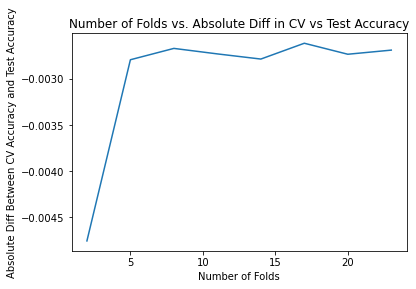

In [52]:
# Relationship between number of folds and cv error
base_tree = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = 10,  min_samples_split = 5,
                              min_samples_leaf = 2)
results = [cross_validate(estimator=base_tree,
                                          X=df2_train_x,
                                          y=df2_train_y,
                                          cv=KFold(n_splits=i),
                                          scoring=make_scorer(accuracy_score))['test_score'].mean() for i in range(2,25,3)]

base_tree.fit(df2_train_x,df2_train_y)
test_accuracy=accuracy_score(base_tree.predict(df2_test_x),df2_test_y)
diff=results-test_accuracy
plt.xlabel("Number of Folds")
plt.ylabel("Absolute Diff Between CV Accuracy and Test Accuracy")
plt.title("Number of Folds vs. Absolute Diff in CV vs Test Accuracy")
plt.plot(range(2,25,3),diff/test_accuracy)


Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 14.0min finished


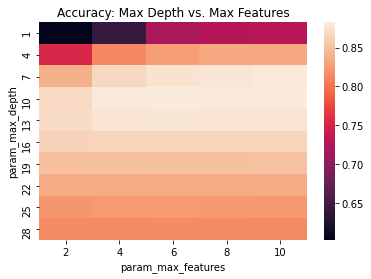

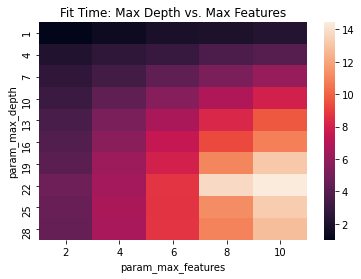

In [14]:
# Parameter tuning for,max_features,max_depth
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

base_tree = tree.DecisionTreeClassifier(criterion = "entropy")

max_depth = range(1, 30, 3)
min_samples_split=range(1,40,5)
min_samples_leaf=range(0,330,30)
max_features=range(2,12,2)
min_impurity_decrease=np.linspace(0.0,0.022,12)

param_grid1 ={'max_depth':max_depth,'max_features':max_features}

grid_search = GridSearchCV(base_tree, param_grid1, n_jobs=-1, cv=kfold, verbose=1,refit=False,scoring='accuracy')
grid_result = grid_search.fit(df2_train_x, df2_train_y)

results=pd.DataFrame(grid_result.cv_results_)

sns.heatmap(results.pivot(index='param_max_depth', columns='param_max_features', values='mean_test_score'))
plt.title('Accuracy: Max Depth vs. Max Features')
plt.show()

sns.heatmap(results.pivot(index='param_max_depth', columns='param_max_features', values='mean_fit_time'))
plt.title('Fit Time: Max Depth vs. Max Features')
plt.show()


Fitting 10 folds for each of 132 candidates, totalling 1320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 1320 out of 1320 | elapsed: 15.2min finished


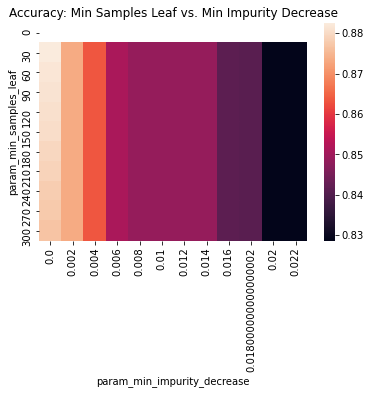

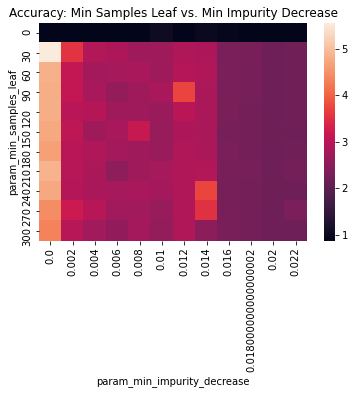

In [69]:
# Parameter tuning for min samples leaf and impurity decrease
param_grid2 ={'min_samples_leaf':min_samples_leaf,'min_impurity_decrease':min_impurity_decrease}
base_tree = tree.DecisionTreeClassifier(criterion = "entropy",max_depth=10,max_features=10)
grid_search = GridSearchCV(base_tree, param_grid2, n_jobs=-1, cv=kfold, verbose=1,refit=False,scoring='accuracy')
grid_result = grid_search.fit(df2_train_x, df2_train_y)

results=pd.DataFrame(grid_result.cv_results_)

sns.heatmap(results.pivot(index='param_min_samples_leaf', columns='param_min_impurity_decrease', values='mean_test_score'))
plt.title('Accuracy: Min Samples Leaf vs. Min Impurity Decrease')
plt.show()

sns.heatmap(results.pivot(index='param_min_samples_leaf', columns='param_min_impurity_decrease', values='mean_fit_time'))
plt.title('Accuracy: Min Samples Leaf vs. Min Impurity Decrease')
plt.show()



# Dataset 1: Neural Net

In [ ]:
# Oversampling Strategy
sample_strategies=[0.005,0.01,0.05,0.1,0.2,0.5]
samples=[oversamples(strategy) for strategy in sample_strategies]
clf = MLPClassifier( alpha=1e-5, random_state=1,batch_size=2400)
models=[deepcopy(clf.fit(sample[0],sample[1])) for sample in samples]
predictions=[model.predict(df_train15_validationx) for model in models]
precisions=[precision_score(prediction,df_train15_validationy) for prediction in predictions]
recalls=[recall_score(prediction,df_train15_validationy) for prediction in predictions]
f1s=[f1_score(prediction,df_train15_validationy) for prediction in predictions]

results=pd.DataFrame(data={'Oversampling Rate':sample_strategies,'F1':f1s,'Recall':recalls,"Precision":precisions})

final_strategy=0.01

In [99]:
final_strategy=0.01
x_data,y_data=oversamples(final_strategy)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

param_grid=dict(hidden_layer_sizes=[tuple([2]*1),tuple([2]*2),tuple([2]*5),tuple([2]*10),tuple([2]*20), \
 tuple([5]*1),tuple([5]*2),tuple([5]*5),tuple([5]*10),tuple([5]*20), \
 tuple([10]*1),tuple([10]*2),tuple([10]*5),tuple([10]*10),tuple([10]*20),\
 tuple([20]*1),tuple([20]*2),tuple([20]*5),tuple([20]*10),tuple([20]*20)])

clf = MLPClassifier( alpha=1e-5, random_state=1,batch_size=2400)

grid_search = GridSearchCV(clf, param_grid=param_grid, scoring=scoring, n_jobs=-1, cv=kfold, verbose=1,refit=False)
grid_result=grid_search.fit(x_data,y_data)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 26.6min finished


Text(0.5, 0.98, 'CV Evalution Metrics by Hidden Network Shape/Size')

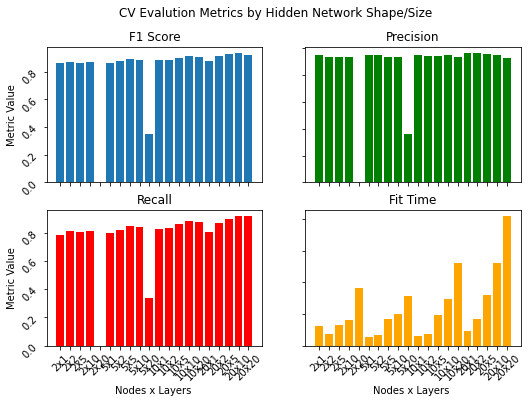

In [100]:
results=pd.DataFrame(grid_result.cv_results_)
layer_sizes=('2x1','2x2','2x5','2x10','2x20','5x1','5x2','5x5','5x10','5x20','10x1','10x2','10x5','10x10','10x20','20x1','20x2','20x5','20x10','20x20')
f1=results['mean_test_f1_score']
precision=results['mean_test_precision']
recall=results['mean_test_recall']
fit_time=results['mean_fit_time']


fig, axs = plt.subplots(2, 2)
axs[0, 0].bar(layer_sizes, f1)
axs[0, 0].set_title('F1 Score')
axs[0, 1].bar(layer_sizes, precision,color='green')
axs[0, 1].set_title('Precision')
axs[1, 0].bar(layer_sizes, recall,color='red')
axs[1, 0].set_title('Recall')
axs[1, 1].bar(layer_sizes, fit_time,color='orange')
axs[1, 1].set_title('Fit Time')

for ax in axs.flat:
    ax.set(xlabel='Nodes x Layers ', ylabel='Metric Value')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.tick_params(labelrotation=45)

fig.set_size_inches(8.5, 5.5)
plt.suptitle('CV Evalution Metrics by Hidden Network Shape/Size')

resultsDF=pd.DataFrame(data={'layer_size':layer_sizes,'precision':precision,'recall':recall,'f1':f1,'train time':fit_time})
final_network_size=tuple([5]*10
                        

# Dataset 2: Neural Nets

In [121]:
# Alpha static, decreasing, network size,
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid=dict(hidden_layer_sizes=[tuple([2]*1),tuple([2]*2),tuple([2]*5),tuple([2]*10),tuple([2]*20), \
 tuple([5]*1),tuple([5]*2),tuple([5]*5),tuple([5]*10),tuple([5]*20), \
 tuple([10]*1),tuple([10]*2),tuple([10]*5),tuple([10]*10),tuple([10]*20),\
 tuple([20]*1),tuple([20]*2),tuple([20]*5),tuple([20]*10),tuple([20]*20)])

clf = MLPClassifier(alpha=1e-5, random_state=1)

grid_search = GridSearchCV(clf, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=kfold, verbose=1,refit=False)
grid_result=grid_search.fit(df2_train_x,df2_train_y)
results=pd.DataFrame(grid_result.cv_results_)
accuracy=results['mean_test_score']
fit_time=results['mean_fit_time']

fig, axs = plt.subplots(2, 1)
axs[0].bar(layer_sizes, accuracy)
axs[0].set_title('Accuracy')
axs[1].bar(layer_sizes, fit_time,color='green')
axs[1].set_title('Fit Time')

for ax in axs.flat:
    ax.set(xlabel='Nodes x Layers ', ylabel='Metric Value')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.tick_params(labelrotation=45)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 44.4min finished


KeyError: 'mean_test_score'

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 40.4min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed: 42.0min finished


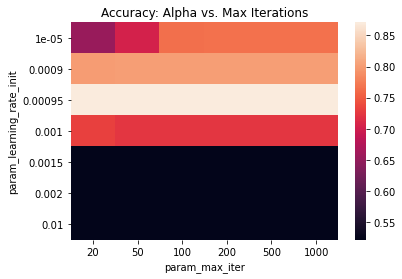

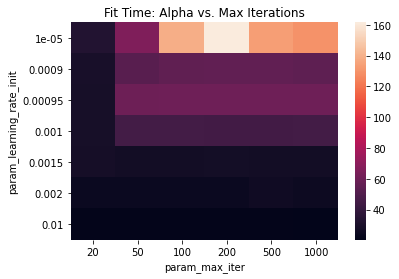

In [157]:
# Constant Learning rates
clf = MLPClassifier(random_state=1,hidden_layer_sizes=(5,10))
learning_rate_inits=[1e-5,9e-4,9.5e-4,1e-3,1.5e-3,2e-3,1e-2]
max_iters=[20,50,100,200,500,1000]

param_grid={'learning_rate_init':learning_rate_inits,'max_iter':max_iters}
grid_search = GridSearchCV(clf, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=kfold, verbose=1,refit=False)
grid_result=grid_search.fit(df2_train_x,df2_train_y)
results=pd.DataFrame(grid_result.cv_results_)

sns.heatmap(results.pivot(index='param_learning_rate_init', columns='param_max_iter', values='mean_test_score'))
plt.title('Accuracy: Learning Rate vs. Max Iterations')
plt.show()

sns.heatmap(results.pivot(index='param_learning_rate_init', columns='param_max_iter', values='mean_fit_time'))
plt.title('Fit Time: Learning Rate vs. Max Iterations')
plt.show()




# Dataset 1: K Nearest Neighbors

In [9]:
train_scale_x=scale(df_train15_trainx)
test_scale_x=scale(df_test15_x)

# Create validation Sets

validations=[df_train15_validation[df_train15_validation['Class']==1].sample(75,replace=True).append(df_train15_validation[df_train15_validation['Class']!=1].sample(5000,replace=True)) for i in range(5)]
validation_xs,validation_ys=[scale(valid.loc[:, valid.columns != 'Class']) for valid in validations],[valid.loc[:, valid.columns == 'Class'] for valid in validations]

def undersamples(strategy):
    undersample=RandomUnderSampler(sampling_strategy=strategy)
    x_over,y_over=undersample.fit_resample(train_scale_x,df_train15_trainy)
    return (x_over,y_over)


sample_strategies=[0.005,0.01,0.05,0.1,0.2,0.5]
ks=[5,20,50,100]

# sample_strategies=[0.005,0.1]
# ks=[1,2]
samples=[undersamples(strategy) for strategy in sample_strategies]
models=[deepcopy(KNeighborsClassifier(n_neighbors=k).fit(sample[0],sample[1].values.ravel())) for sample in samples for k in ks]

samples_ks=[(sample,k) for sample in sample_strategies for k in ks]
samples_ks_df=pd.DataFrame(data={'sample':[d[0] for d in samples_ks],'k':[d[1] for d in samples_ks]})

results=pd.DataFrame()
for i in range(len(validations)):
    print(i)
    start = time.time()
    results_temp=pd.DataFrame()
    predictions=[model.predict(validation_xs[i]) for model in models]
    end = time.time()
    train_time=end-start
    results_temp['precision']=[precision_score(prediction,validation_ys[i]) for prediction in predictions]
    results_temp['recall']=[recall_score(prediction,validation_ys[i]) for prediction in predictions]
    results_temp['f1']=[f1_score(prediction,validation_ys[i]) for prediction in predictions]
    results_temp['sample']=pd.DataFrame(samples_ks_df)['sample']
    results_temp['k']=pd.DataFrame(samples_ks_df)['k']
    results_temp['predict_time']=[train_time for k in range(len(predictions))]
    results=results.append(results_temp)
    
    
results_agg=results.groupby(['k','sample']).mean().reset_index()

sns.heatmap(results_agg.pivot(index='k',columns='sample',values='f1'))
plt.title('F1 Score K vs. Undersample Rate')
plt.show()
sns.heatmap(results_agg.pivot(index='k',columns='sample',values='recall'))
plt.title('Recall Score K vs. Undersample Rate')
plt.show()
sns.heatmap(results_agg.pivot(index='k',columns='sample',values='precision'))
plt.title('Precision Score K vs. Undersample Rate')
plt.show()

results_agg.loc[(np.where((results_agg['recall']>0.90) & (results_agg['precision']>0.70)))]

final_strategy=0.5
final_k=50

final_x,final_y=undersamples(final_strategy)
knn=KNeighborsClassifier(n_neighbors=final_k).fit(final_x,final_y.values.ravel())
test_predictions=knn.predict(test_scale_x)
output=[precision_score(test_predictions,df_test15_y)

0
1
2
3
4


,precision,recall,f1,sample,k,predict_time
0,0.600000,0.978261,0.743802,0.005,5,95.728476
1,0.626667,0.979167,0.764228,0.005,20,95.728476
2,0.626667,0.979167,0.764228,0.005,50,95.728476
3,0.586667,0.977778,0.733333,0.005,100,95.728476
4,0.586667,0.936170,0.721311,0.010,5,95.728476
...,...,...,...,...,...,...
19,0.613333,1.000000,0.760331,0.200,100,96.614783
20,0.800000,0.689655,0.740741,0.500,5,96.614783
21,0.733333,0.901639,0.808824,0.500,20,96.614783
22,0.733333,0.948276,0.827068,0.500,50,96.614783


In [ ]:
def distance_w_weights(d1,d2,weighted_features,distance_type):
    raw_distance=abs(d1-d2) if distance_type=='manhattan'else (d1-d2)^2
    weighted_distance=np.dot(weighted_features,raw_distance)
    return(weighted_distance)

# knn =KNeighborsClassifier(n_neighbors=final_k,metric=distance_w_weights,metric_params={'weighted_features':params[0],'distance_type':params[1]})
weight_factors=[0,0.1,0.25,0.5,1,2,5]
weights=[list(map(lambda x:pow(x,i),importances10[importances10['rank']<=15]['importance'])) for i in weight_factors]

models=[deepcopy(KNeighborsClassifier(n_jobs=-1,n_neighbors=final_k,metric=distance_w_weights,metric_params={'weighted_features':weight,'distance_type':'manhattan'}).fit(final_x,final_y.values.ravel())) for weight in weights]

validations=[df_train15_validation[df_train15_validation['Class']==1].sample(75,replace=True).append(df_train15_validation[df_train15_validation['Class']!=1].sample(5000,replace=True)) for i in range(5)]
validation_xs,validation_ys=[scale(valid.loc[:, valid.columns != 'Class']) for valid in validations],[valid.loc[:, valid.columns == 'Class'] for valid in validations]


results=pd.DataFrame()
for i in range(len(validations)):
    print(i)
    start = time.time()
    results_temp=pd.DataFrame()
    predictions=[model.predict(validation_xs[i]) for model in models]
    end = time.time()
    train_time=end-start
    results_temp['precision']=[precision_score(prediction,validation_ys[i].values.ravel()) for prediction in predictions]
    results_temp['recall']=[recall_score(prediction,validation_ys[i].values.ravel()) for prediction in predictions]
    results_temp['f1']=[f1_score(prediction,validation_ys[i].values.ravel()) for prediction in predictions]
    results_temp['predict_time']=[train_time for k in range(len(predictions))]
    results_temp['n']=weight_factors
    results=results.append(results_temp)
    
results.groupby('n').mean()

#  Dataset 2: KNN

In [79]:
train_scale_x=scale(df2_train_x)
test_scale_x=scale(df2_test_x)

fold=[-1]*(len(train_scale_x)-500)+[0]*100+[1]*100+[2]*100+[3]*100+[4]*100
shuffle(fold)

knn=KNeighborsClassifier(n_neighbors=5,metric='wminkowski')

param_grid={'metric_params':[{'w':1+np.eye(10)[i]} for i in range(10)]+[{'w':1-0.5*np.eye(10)[i]} for i in range(10)]+[{'w':np.ones(10)},{'w':[0,0,0,1,1,1,0,1,1,1]}]+[{'w':[0,0,0,2,1,1,0,1,2,1]},{'w':[0,0,0,5,1,1,0,1,5,1]},{'w':[0,0,0,10,1,1,0,1,10,1]},{'w':[0,0,0,5,1,1,0,1,2,1]},{'w':[0,0,0,2,1,1,0,1,5,1]}]}

ps = PredefinedSplit(test_fold=fold)

grid_search = GridSearchCV(knn, param_grid, scoring='accuracy', n_jobs=-1, cv=ps, verbose=1,refit=False)
grid_result=grid_search.fit(train_scale_x,df2_train_y.values.ravel())

pd.DataFrame(grid_result.cv_results_)['mean_test_score']


Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 11.2min finished


0     0.764
1     0.764
2     0.766
3     0.778
4     0.762
5     0.766
6     0.764
7     0.754
8     0.774
9     0.750
10    0.770
11    0.764
12    0.764
13    0.758
14    0.762
15    0.766
16    0.766
17    0.762
18    0.760
19    0.774
20    0.766
21    0.800
22    0.824
23    0.822
24    0.830
25    0.824
26    0.830
Name: mean_test_score, dtype: float64

In [81]:
knn=KNeighborsClassifier(n_neighbors=5,metric='wminkowski',metric_params={'w':[0,0,0,10,1,1,0,1,10,1]})
param_grid={'n_neighbors':[1,5,10,20,50,100,250],'weights':['uniform','distance']}

grid_search = GridSearchCV(knn, param_grid, scoring='accuracy', n_jobs=-1, cv=ps, verbose=1,refit=False)
grid_result=grid_search.fit(train_scale_x,df2_train_y.values.ravel())

results=pd.DataFrame(grid_result.cv_results_)

sns.lineplot(data=results, x="param_n_neighbors", y="mean_test_score", hue="param_weights")
plt.title('KNN Accuracy: Number of Neighbors vs. Weight Type')

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed: 10.4min finished


# Dataset 1: Boosting

In [24]:
# At this point, I realized that there's a more elegant way to perform a hyperparameter search with a prespecified validation set

# Im appending the validation set to the training set
# Then the validation set will be defined as a predefined split so that it is used for validation and not training
def oversamples(strategy):
    if strategy=='balanced':
        x_over,y_over=df_train15_trainx,df_train15_trainy
    else:
        oversample=RandomOverSampler(sampling_strategy=strategy)
        x_over,y_over=oversample.fit_resample(df_train15_trainx,df_train15_trainy)
    return (x_over.append(df_train15_validationx_fixed),y_over.append(df_train15_validationy_fixed))


xgb=xgbc(objective="binary:logistic",eval_metric='logloss',use_label_encoder=False)

sample_strategies=['balanced',0.005,0.01,0.05,0.1,0.2,0.5]
pos_weights=[1,10,25,50,250,500,1000,10000]
etas=[0.3,0.5,0.7,0.9]
max_depths=[3,6,9,12,15]

samples=[oversamples(strategy) for strategy in sample_strategies]
splits=[PredefinedSplit(test_fold=[-1]*(len(samples[i][0])-len(df_train15_validationx_fixed))+[0]*len(df_train15_validationx_fixed)) for i in range(len(samples))]

scoring = {'f1': 'f1', 'precision': 'precision','recall':'recall'}

param_grid={'scale_pos_weight':pos_weights,'eta':etas,'max_depth':max_depths}
grid_results=[(sample_strategies[i],GridSearchCV(xgb,param_grid,scoring=scoring,n_jobs=-1,verbose=1,refit=False,cv=splits[i]).fit(samples[i][0],samples[i][1].values.ravel())) for i in range(len(samples))]

cv_results=[pd.DataFrame(result[1].cv_results_) for result in grid_results]

[cv_results[i].insert(2,'sample_rate',sample_strategies[i]) for i in range(len(cv_results))]

cv_results=pd.concat(cv_results)
cv_results['sample_rate_rank']=pd.DataFrame([0.002 if rate=='balanced' else float(rate) for rate in cv_results['sample_rate']]).rank(method='dense')
cv_results['pos_weights_rank']=cv_results['param_scale_pos_weight'].rank(method='dense')
cv_results['max_depths_rank']=cv_results['param_max_depth'].rank(method='dense')
cv_results['etas_rank']=cv_results['param_eta'].rank(method='dense')
cv_results['rank_f1']=cv_results['mean_test_f1'].rank(method='dense',ascending=False)
cv_results['rank_recall']=cv_results['mean_test_recall'].rank(method='dense',ascending=False)
cv_results['rank_precision']=cv_results['mean_test_precision'].rank(method='dense',ascending=False)

cv_results_long=cv_results[['sample_rate_rank','pos_weights_rank','max_depths_rank','etas_rank','rank_precision','rank_recall','rank_f1']]
cv_results_long=cv_results_long.melt(value_vars=['sample_rate_rank','pos_weights_rank','max_depths_rank','etas_rank'],id_vars=['rank_precision','rank_recall','rank_f1'])

# cv_results_long=cv_results_long[cv_results_long['value']!='etas_rank']
sns.lineplot(data=cv_results_long,x='rank_recall',y='value',hue='variable',ci=None)
plt.title('Hyperparameter Ranks by Model Recall Rank')
plt.show()

# Precision
sns.lineplot(data=cv_results_long,x='rank_precision',y='value',hue='variable',ci=None)
plt.title('Hyperparameter Ranks by Model Precision Rank')
plt.show()

cv_overall=cv_results.melt(id_vars=['rank_f1'],value_vars=['mean_test_f1','mean_test_precision','mean_test_recall'])
sns.lineplot(data=cv_overall,x='rank_f1',y='value',hue='variable',ci=None)
plt.title('Model Error Metrics')
plt.show()

cv_results[cv_results['rank_f1']<=5][['sample_rate','param_scale_pos_weight','param_max_depth','param_eta','mean_test_f1','mean_test_recall','mean_test_precision']]


final_sample_rate='balanced'
final_scale_pos_weight=10
final_max_depth=9
final_eta=0.7




Fitting 1 folds for each of 160 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 30.0min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 81.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 1 folds for each of 160 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 68.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 1 folds for each of 160 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 44.5min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 107.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 1 folds for each of 160 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 70.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 1 folds for each of 160 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 73.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 1 folds for each of 160 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 30.5min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 91.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 1 folds for each of 160 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 31.1min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 91.4min finished


# Data Set 2 Boosting

In [28]:
xgb=xgbc(use_label_encoder=False)
tree_methods=['exact', 'approx', 'hist', 'gpu_hist']
param_grid={'tree_method':tree_methods}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
resultsD2=GridSearchCV(xgb,param_grid,scoring='accuracy',n_jobs=-1,verbose=1,refit=False,cv=kfold).fit(df2_train_x,df2_train_y)

results_d2=pd.DataFrame(resultsD2.cv_results_)

results_d2

results_d2.to_csv('dataset2_tree_method.csv')

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 17.3min finished


In [33]:
etas=[0.3,0.5,0.7,0.9]
max_depths=[3,6,10,15,30,50]
subsamples=[0.5,0.75,0.9,1]

xgb=xgbc(tree_method='hist',use_label_encoder=False)
param_grid={'eta':etas,'max_depth':max_depths,'subsample':subsamples}
resultsD2_2=GridSearchCV(xgb,param_grid,scoring='accuracy',n_jobs=-1,verbose=1,refit=False).fit(df2_train_x,df2_train_y)

results_d22=pd.DataFrame(resultsD2_2.cv_results_)

results_d22.to_csv('dataset2_2.csv')

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 93.9min
C:\Users\Rory\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 199.3min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 219.8min finished


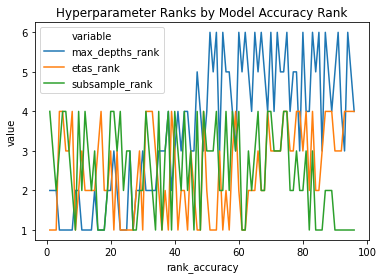

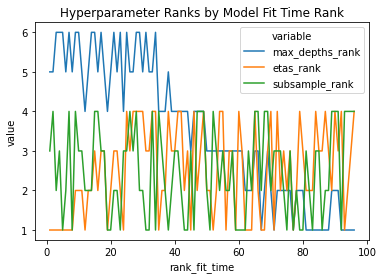

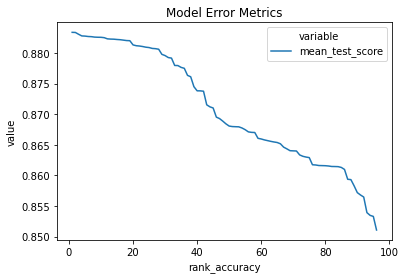

In [181]:
results_d22['max_depths_rank']=results_d22['param_max_depth'].rank(method='dense')
results_d22['etas_rank']=results_d22['param_eta'].rank(method='dense')
results_d22['subsample_rank']=results_d22['param_subsample'].rank(method='dense')
results_d22['rank_accuracy']=results_d22['mean_test_score'].rank(method='dense',ascending=False)
results_d22['rank_fit_time']=results_d22['mean_fit_time'].rank(method='dense',ascending=False)


results_d22_long=results_d22[['max_depths_rank','etas_rank','subsample_rank','rank_accuracy','mean_fit_time']]
results_d22_long=results_d22.melt(value_vars=['max_depths_rank','etas_rank','subsample_rank'],id_vars=['rank_accuracy','rank_fit_time'])

sns.lineplot(data=results_d22_long,x='rank_accuracy',y='value',hue='variable',ci=None)
plt.title('Hyperparameter Ranks by Model Accuracy Rank')
plt.show()


sns.lineplot(data=results_d22_long,x='rank_fit_time',y='value',hue='variable',ci=None)
plt.title('Hyperparameter Ranks by Model Fit Time Rank')
plt.show()

results_d22_overall=results_d22.melt(id_vars=['rank_accuracy'],value_vars=['mean_test_score'])
sns.lineplot(data=results_d22_overall,x='rank_accuracy',y='value',hue='variable',ci=None)
plt.title('Model Error Metrics')
plt.show()

results_d22[results_d22['rank_accuracy']<=5][['param_max_depth','param_eta','param_subsample','mean_fit_time','mean_test_score']]
final_max_depth=9
final_eta=0.7
final_tree_method='hist'
final_subsample=1


# Dataset 1 SVM

In [28]:
weights = np.linspace(0.0,0.45,5)
class_weights=['balanced']+[{0:round(x,1), 1:round(1.0-x,1)} for x in weights]

param_grid = [
    {'kernel': ["linear","rbf","sigmoid"],
      'cache_size': [200,1000,2500],
      'class_weight': class_weights},
    {'kernel': ["poly"],
      'cache_size': [200,1000,2500],
      'class_weight': class_weights,
       'degree':[3,6,9,12]}
    ]

undersample=RandomUnderSampler(sampling_strategy=0.005)
x_under,y_under=undersample.fit_resample(df_train15_trainx,df_train15_trainy)


train_scale_x=pd.DataFrame(scale(x_under))
validation_scale_x=pd.DataFrame(scale(df_train15_validationx_fixed))
train_scale_xv=train_scale_x.append(validation_scale_x)
df_train15_y=pd.DataFrame(y_under).append(pd.DataFrame(df_train15_validationy_fixed))
test_scale_x=scale(df_test15_x)

ps= PredefinedSplit(test_fold=[-1]*len(train_scale_x)+[0]*len(validation_scale_x))
scoring = {'f1': 'f1', 'precision': 'precision','recall':'recall'}
svm=SVC()
results=GridSearchCV(svm,param_grid,scoring=scoring,n_jobs=-1,verbose=2,refit=False,cv=ps).fit(train_scale_xv,df_train15_y.values.ravel())

results_pd=pd.DataFrame(results.cv_results_)
results_pd.to_csv('svm1.csv')

svm1=pd.read_csv('svm1.csv')
svm1.loc[svm1['rank_test_f1']<10][['param_kernel','param_class_weight','param_cache_size','mean_test_f1','mean_fit_time']].sort_values(by=['mean_test_f1'],ascending=False)

# class_weight_final={0: 0.2, 1: 0.8}
# cache_size_final=200
# kernel_final='linear'



,param_kernel,param_class_weight,param_cache_size,mean_test_f1,mean_fit_time
12,linear,"{0: 0.3, 1: 0.7}",200,0.797619,12.147077
15,linear,"{0: 0.4, 1: 0.6}",200,0.797619,12.388536
30,linear,"{0: 0.3, 1: 0.7}",1000,0.797619,11.977276
33,linear,"{0: 0.4, 1: 0.6}",1000,0.797619,12.317244
48,linear,"{0: 0.3, 1: 0.7}",2500,0.797619,81.770335
51,linear,"{0: 0.4, 1: 0.6}",2500,0.797619,88.717009
9,linear,"{0: 0.2, 1: 0.8}",200,0.792899,12.009732
27,linear,"{0: 0.2, 1: 0.8}",1000,0.792899,11.942183
45,linear,"{0: 0.2, 1: 0.8}",2500,0.792899,77.209975


# Dataset 2 SVM

In [35]:

param_grid = [
    {'kernel': ["linear","rbf","sigmoid"],
      'cache_size': [50,100,200]},
    {'kernel': ["poly"],
      'cache_size': [50,100,200],
       'degree':[3,6,9,12]}
    ]

train_scale_x=pd.DataFrame(scale(df2_train_x))
train_scale_x
test_scale_x=scale(df2_test_x)

train_scale_x=train_scale_x.loc[:,~train_scale_x.columns.isin(['category','main_category','currency','country'])]

sample_index=sample(range(len(train_scale_x)),40000)

svm=SVC()
results=GridSearchCV(svm,param_grid,scoring='accuracy',n_jobs=-1,verbose=2,refit=False).fit(train_scale_x.iloc[sample_index],df2_train_y.iloc[sample_index].values.ravel())

results2_pd=pd.DataFrame(results.cv_results_)
results2_pd.to_csv('svm2.csv')

svm2=pd.read_csv('svm2.csv')
svm2.loc[svm2['rank_test_score']<15][['param_kernel','param_degree','param_cache_size','mean_test_score','mean_fit_time']].sort_values(by=['mean_test_score'],ascending=False)

# cache_size_final=50
# kernel_final='linear'


,param_kernel,param_degree,param_cache_size,mean_test_score,mean_fit_time
0,linear,NaN,50,0.73545,15.966260
3,linear,NaN,100,0.73545,16.542272
6,linear,NaN,200,0.73545,19.661070
1,rbf,NaN,50,0.69285,17.195355
4,rbf,NaN,100,0.69285,17.348246
7,rbf,NaN,200,0.69285,20.854289
9,poly,3.0,50,0.58380,39.425305
13,poly,3.0,100,0.58380,35.594466
17,poly,3.0,200,0.58380,37.962857
10,poly,6.0,50,0.54715,59.464350


# Final Models and Learning Curves

# Dataset 1

In [33]:
df_train15_x=df_train15.loc[:, df_train15.columns != 'Class']
df_train15_y=df_train15.loc[:, df_train15.columns == 'Class']

# For each model, define the hyperparameters and the data used for training/testing

#Decision tree
dt_final_1=tree.DecisionTreeClassifier(criterion = "entropy", min_samples_split = 5,
                              min_samples_leaf = 2,class_weight={0:0.99,1:0.01},max_depth=5)
dt_train_x,dt_train_y=RandomOverSampler(sampling_strategy=0.1).fit_resample(df_train15_x,df_train15_y)
dt_test_x=df_test15_x

#Neural Net
mlp_final_1=MLPClassifier( alpha=1e-5, random_state=1,batch_size=2400,hidden_layer_sizes=tuple([5]*10))
mlp_train_x,mlp_train_y=RandomOverSampler(sampling_strategy=0.01).fit_resample(df_train15_x,df_train15_y)
mlp_test_x=df_test15_x

# K-nearest neighbors
knn_final_1=KNeighborsClassifier(n_neighbors=50)
knn_train_x,knn_train_y=RandomUnderSampler(sampling_strategy=0.5).fit_resample(scale(df_train15_x),df_train15_y)
knn_test_x=scale(df_test15_x)

# Boosting
boost_final_1=xgbc(objective="binary:logistic",eval_metric='logloss',
                   use_label_encoder=False,scale_pos_weight=10,max_depth=9,final_eta=0.7)
boost_train_x,boost_train_y=df_train15_x,df_train15_y
boost_test_x=df_test15_x

# Support Vector Machines
svm_final_1=SVC(class_weight={0: 0.2, 1: 0.8},cache_size=200,kernel='linear')
svm_train_x,svm_train_y=RandomUnderSampler(sampling_strategy=0.005).fit_resample(scale(df_train15_trainx),df_train15_trainy)
svm_train_x,svm_train_y=sh(np.array(svm_train_x),np.array(svm_train_y))
svm_test_x=scale(df_test15_x)

# # # Learning Curves
# Dataset 1
## Decision Tree
results_dt1=(dt1_train_sizes,dt1_train_scores_mean,dt1_test_scores_mean,dt1_fit_times_mean)=c_learning_curve(dt_final_1,dt_train_x,dt_train_y,'f1','k')
results_dt1_pd=pd.DataFrame(results_dt1)
results_dt1_pd.to_csv('results/dt1.csv')

print('DT Complete')

## Neural Net
results_mlp1=(mlp1_train_sizes,mlp1_train_scores_mean,mlp1_test_scores_mean,mlp1_fit_times_mean)=c_learning_curve(mlp_final_1,mlp_train_x,mlp_train_y,'f1','k')
results_mlp1_pd=pd.DataFrame(results_mlp1)
results_mlp1_pd.to_csv('results/mlp1.csv')

print('NN Complete')

# K Nearest Neighbors
results_knn1=(knn1_train_sizes,knn1_train_scores_mean,knn1_test_scores_mean,knn1_fit_times_mean)=c_learning_curve(knn_final_1,knn_train_x,knn_train_y,'f1','k')
results_knn1_pd=pd.DataFrame(results_knn1)
results_knn1_pd.to_csv('results/knn1.csv')

print('KNN Complete')

#Boosting
results_boost1=(boost1_train_sizes,boost1_train_scores_mean,boost1_test_scores_mean,boost1_fit_times_mean)=c_learning_curve(boost_final_1,boost_train_x,boost_train_y,'f1','k')
results_boost1_pd=pd.DataFrame(results_boost1)
results_boost1_pd.to_csv('results/boost1.csv')

print('Boosting Complete')

# Svm
results_svm1=(svm1_train_sizes,svm1_train_scores_mean,svm1_train_scores_std,svm1_test_scores_mean,svm1_test_scores_std,svm1_fit_times_mean,svm1_fit_times_std)=c_learning_curve(svm_final_1,svm_train_x,svm_train_y,'f1','k')
results_svm1_pd=pd.DataFrame(results_svm1)
results_svm1_pd.to_csv('results/svm1.csv')

print('SVM Complete')


DT Complete
NN Complete
KNN Complete


NameError: name 'reesluts_boost1' is not defined

In [36]:
# results_boost1_pd=pd.DataFrame(results_boost1)
# results_boost1_pd.to_csv('results/boost1.csv')

# print('Boosting Complete')

# # Svm
results_svm1=(svm1_train_sizes,svm1_train_scores_mean,svm1_test_scores_mean,svm1_fit_times_mean)=c_learning_curve(svm_final_1,svm_train_x,svm_train_y,'f1','k')
results_svm1_pd=pd.DataFrame(results_svm1)
results_svm1_pd.to_csv('results/svm1.csv')

print('SVM Complete')

SVM Complete


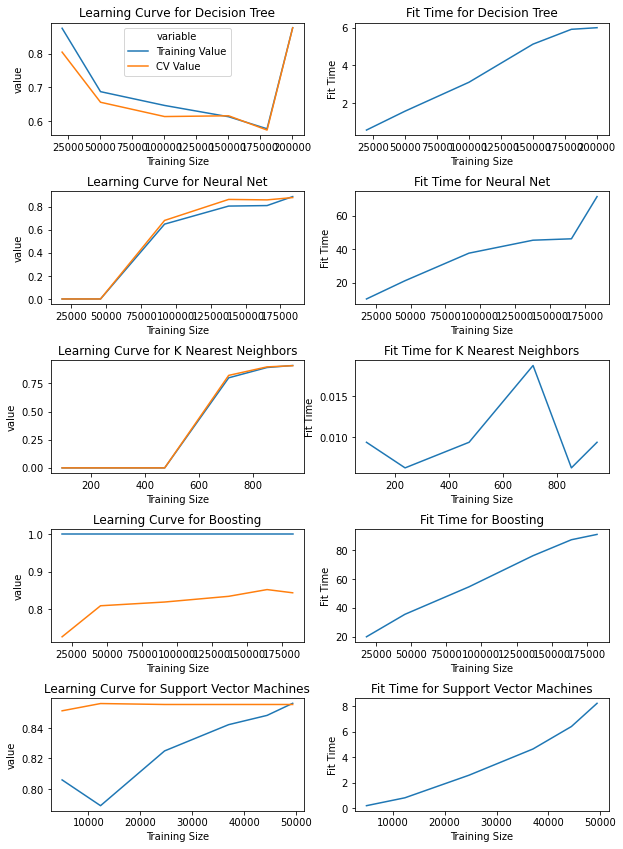

In [38]:
# PLotting the learning curve
fig, axs = plt.subplots(5, 2)
fig.set_size_inches(10, 14.5)
fig.subplots_adjust(hspace=.5)
    
results_dt1=pd.read_csv('results/dt1.csv')
results_mlp1=pd.read_csv('results/mlp1.csv')
results_knn1=pd.read_csv('results/knn1.csv')
results_boost1=pd.read_csv('results/boost1.csv')
results_svm1=pd.read_csv('results/svm1.csv')

plot_learning_curve(results_dt1,0,'Decision Tree')
plot_learning_curve(results_mlp1,1, 'Neural Net')
plot_learning_curve(results_knn1,2,'K Nearest Neighbors')
plot_learning_curve(results_boost1,3, 'Boosting')
plot_learning_curve(results_svm1,4,'Support Vector Machines')


# Dataset 1: Final Models


In [39]:
final_test1=pd.DataFrame()
dt_final_1.fit(dt_train_x,dt_train_y)
result=pd.DataFrame(data={'Model':['Decision Tree'],'Training F1':[f1_score(dt_final_1.predict(dt_train_x),dt_train_y)],'Test F1':[f1_score(dt_final_1.predict(dt_test_x),df_test15_y)]})
final_test1=final_test1.append(result)

mlp_final_1.fit(mlp_train_x,mlp_train_y)
result=pd.DataFrame(data={'Model':['Neural Net'],'Training F1':[f1_score(mlp_final_1.predict(mlp_train_x),mlp_train_y)],'Test F1':[f1_score(mlp_final_1.predict(mlp_test_x),df_test15_y)]})
final_test1=final_test1.append(result)

knn_final_1.fit(knn_train_x,knn_train_y)
result=pd.DataFrame(data={'Model':['K Nearest Neighbors'],'Training F1':[f1_score(knn_final_1.predict(knn_train_x),knn_train_y)],'Test F1':[f1_score(knn_final_1.predict(knn_test_x),df_test15_y)]})
final_test1=final_test1.append(result)

boost_final_1.fit(boost_train_x,boost_train_y)
result=pd.DataFrame(data={'Model':['Boosting'],'Training F1':[f1_score(boost_final_1.predict(boost_train_x),boost_train_y)],'Test F1':[f1_score(boost_final_1.predict(boost_test_x),df_test15_y)]})
final_test1=final_test1.append(result)

svm_final_1.fit(svm_train_x,svm_train_y)
result=pd.DataFrame(data={'Model':['Support Vector Machines'],'Training F1':[f1_score(svm_final_1.predict(svm_train_x),svm_train_y)],'Test F1':[f1_score(svm_final_1.predict(svm_test_x),df_test15_y)]})
final_test1=final_test1.append(result)


C:\Users\Rory\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
<ipython-input-39-6d1e2f6745cb>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn_final_1.fit(knn_train_x,knn_train_y)


[15:02:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { final_eta } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\Rory\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


# Dataset 2

In [13]:

# For each model, define the hyperparameters and the data used for training/testing
# Decision tree
dt_final_2=tree.DecisionTreeClassifier(criterion = "entropy",max_depth=10,max_features=10,
                                       min_samples_leaf=2,min_impurity_decrease=0)
dt2_train_x,dt2_train_y=df2_train_x,df2_train_y
dt2_test_x=df2_test_x

# Neural Net
mlp_final_2=MLPClassifier(random_state=1,hidden_layer_sizes=[5]*10,learning_rate_init=0.00095)
mlp2_train_x,mlp2_train_y=df2_train_x,df2_train_y
mlp2_test_x=df2_test_x

# # K nearest neighbors
knn_final_2=KNeighborsClassifier(n_neighbors=25,metric='wminkowski',
                                 metric_params={'w':[0,0,0,10,1,1,0,1,10,1]},weights='uniform')

sample_index=sample(range(len(df2_train_x)),5000)
knn2_train_x,knn2_train_y=scale(df2_train_x.iloc[sample_index]),df2_train_y.iloc[sample_index].values.ravel()
knn2_test_x=scale(df2_test_x)

#Boosting
boost_final_2=xgbc(tree_method='hist',use_label_encoder=False,subsample=1,eta=0.7,max_depth=9)
boost2_train_x,boost2_train_y=df2_train_x,df2_train_y
boost2_test_x=df2_test_x

#SVM
svm_final_2=SVC(cache_size=50,kernel='linear')
sample_index=sample(range(len(df2_train_x)),40000)
svm2_train_x,svm2_train_y=scale(df2_train_x.iloc[sample_index]),df2_train_y.iloc[sample_index].values.ravel()
svm2_test_x=scale(df2_test_x)


# Learning Curves
## Decision Tree
results_dt2=(dt2_train_sizes,dt2_train_scores_mean,dt2_test_scores_mean,dt2_fit_times_mean)=c_learning_curve(dt_final_2,dt2_train_x,dt2_train_y,'accuracy','k')
results_dt2_pd=pd.DataFrame(results_dt2)
results_dt2_pd.to_csv('results/dt2.csv')

print('DT Complete')

## Neural Net

results_mlp2=(mlp2_train_sizes,mlp2_train_scores_mean,mlp2_test_scores_mean,mlp2_fit_times_mean)=c_learning_curve(mlp_final_2,mlp2_train_x,mlp2_train_y,'accuracy','k')
results_mlp2_pd=pd.DataFrame(results_mlp2)
results_mlp2_pd.to_csv('results/mlp2.csv')

print('NN Complete')

# K Nearest Neighbors
results_knn2=(knn2_train_sizes,knn2_train_scores_mean,knn2_test_scores_mean,knn2_fit_times_mean)=c_learning_curve(knn_final_2,knn2_train_x,knn2_train_y,'accuracy','ps')
results_knn2_pd=pd.DataFrame(results_knn2)
results_knn2_pd.to_csv('results/knn2.csv')

print('KNN Complete')


# # #Boosting
results_boost2=(boost2_train_sizes,boost2_train_scores_mean,boost2_test_scores_mean,boost2_fit_times_mean)=c_learning_curve(boost_final_2,boost2_train_x,boost2_train_y,'accuracy','k')
results_boost2_pd=pd.DataFrame(results_boost2)
results_boost2_pd.to_csv('results/boost2.csv')

print('Boosting Complete')

# Svm
results_svm2=(svm2_train_sizes,svm2_train_scores_mean,svm2_test_scores_mean,svm2_fit_times_mean)=c_learning_curve(svm_final_2,svm2_train_x,svm2_train_y,'accuracy','k')
results_svm2_pd=pd.DataFrame(results_svm2)
results_svm2_pd.to_csv('results/svm2.csv')

print('SVM Complete')


DT Complete
NN Complete
KNN Complete
Boosting Complete


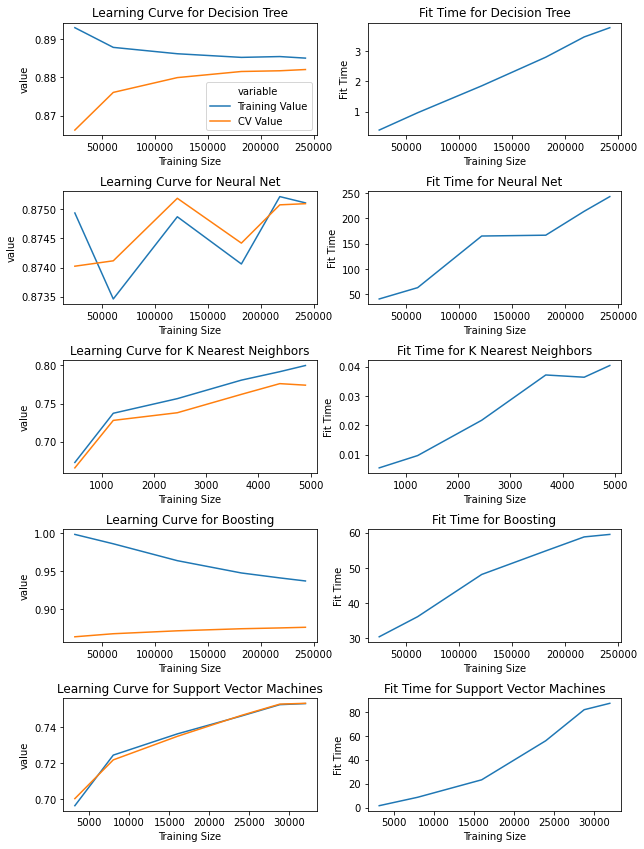

In [24]:


mlp_final_2=MLPClassifier(random_state=1,hidden_layer_sizes=[5]*10,learning_rate_init=0.00095)
mlp2_train_x,mlp2_train_y=df2_train_x,df2_train_y
mlp2_test_x=df2_test_x


results_mlp2=(mlp2_train_sizes,mlp2_train_scores_mean,mlp2_test_scores_mean,mlp2_fit_times_mean)=c_learning_curve(mlp_final_2,mlp2_train_x,mlp2_train_y,'accuracy','k')
results_mlp2_pd=pd.DataFrame(results_mlp2)
results_mlp2_pd.to_csv('results/mlp2.csv')

# PLotting the learning curve
results_dt2=pd.read_csv('results/dt2.csv')
results_mlp2=pd.read_csv('results/mlp2.csv')
results_knn2=pd.read_csv('results/knn2.csv')
results_boost2=pd.read_csv('results/boost2.csv')
results_svm2=pd.read_csv('results/svm2.csv')

fig, axs = plt.subplots(5, 2)
fig.set_size_inches(10, 14.5)
fig.subplots_adjust(hspace=.5)

plot_learning_curve(results_dt2,0,'Decision Tree')
plot_learning_curve(results_mlp2,1, 'Neural Net')
plot_learning_curve(results_knn2,2,'K Nearest Neighbors')
plot_learning_curve(results_boost2,3, 'Boosting')
plot_learning_curve(results_svm2,4,'Support Vector Machines')

# Dataset two final models

In [25]:

final_test2=pd.DataFrame()
dt_final_2.fit(dt2_train_x,dt2_train_y)
result=pd.DataFrame(data={'Model':['Decision Tree'],'Training accuracy':[accuracy_score(dt_final_2.predict(dt2_train_x),dt2_train_y)],'Test accuracy':[accuracy_score(dt_final_2.predict(dt2_test_x),df2_test_y)]})
final_test2=final_test2.append(result)

mlp_final_2.fit(mlp2_train_x,mlp2_train_y)
result=pd.DataFrame(data={'Model':['Neural Net'],'Training accuracy':[accuracy_score(mlp_final_2.predict(mlp2_train_x),mlp2_train_y)],'Test accuracy':[accuracy_score(mlp_final_2.predict(mlp2_test_x),df2_test_y)]})
final_test2=final_test2.append(result)

knn_final_2.fit(knn2_train_x,knn2_train_y)
sample_index=sample(range(len(knn2_train_x)),500)
validate_x=pd.DataFrame(knn2_train_x).iloc[sample_index]
validate_y=pd.DataFrame(knn2_train_y).iloc[sample_index]
sample_index_test=sample(range(len(knn2_test_x)),500)
test_x=pd.DataFrame(knn2_test_x).iloc[sample_index_test]
test_y=pd.DataFrame(df2_test_y).iloc[sample_index_test]
result=pd.DataFrame(data={'Model':['K Nearest Neighbors'],'Training accuracy':[accuracy_score(knn_final_2.predict(validate_x),validate_y)],'Test accuracy':[accuracy_score(knn_final_2.predict(test_x),test_y)]})
final_test2=final_test2.append(result)

boost_final_2.fit(boost2_train_x,boost2_train_y)
result=pd.DataFrame(data={'Model':['Boosting'],'Training accuracy':[accuracy_score(boost_final_2.predict(boost2_train_x),boost2_train_y)],'Test accuracy':[accuracy_score(boost_final_2.predict(boost2_test_x),df2_test_y)]})
final_test2=final_test2.append(result)

svm_final_2.fit(svm2_train_x,svm2_train_y)
result=pd.DataFrame(data={'Model':['Support Vector Machines'],'Training accuracy':[accuracy_score(svm_final_2.predict(svm2_train_x),svm2_train_y)],'Test accuracy':[accuracy_score(svm_final_2.predict(svm2_test_x),df2_test_y)]})
final_test2=final_test2.append(result)

final_test2


C:\Users\Rory\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[14:02:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
